In [ ]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Download and load data
file_id = '1nokkaYBBXswLKA0erqj1JRRi-JXtO_Uj'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'Cleaned_Sleep_Data.csv', quiet=False)

df = pd.read_csv('Cleaned_Sleep_Data.csv')

# Prepare target variable
conditions = [
    (df['Sleep Disorder_Insomnia'] == 1),
    (df['Sleep Disorder_Sleep Apnea'] == 1)
]
choices = [1, 2]
y = np.select(conditions, choices, default=0)

# Prepare features
X = df.drop(['Sleep Disorder_Insomnia', 'Sleep Disorder_Sleep Apnea'], axis=1)

print("=== STEP 1: DATA SPLITTING ===")
print(f"Original dataset shape: {X.shape}")

# Split into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Check class distribution
print("\nClass distribution in each set:")
print("Training set:", np.bincount(y_train))
print("Validation set:", np.bincount(y_val))
print("Test set:", np.bincount(y_test))

Downloading...
From: https://drive.google.com/uc?id=1nokkaYBBXswLKA0erqj1JRRi-JXtO_Uj
To: /content/Cleaned_Sleep_Data.csv
100%|██████████| 1.85M/1.85M [00:00<00:00, 116MB/s]

=== STEP 1: DATA SPLITTING ===
Original dataset shape: (15000, 25)
Training set shape: (9000, 25)
Validation set shape: (3000, 25)
Test set shape: (3000, 25)

Class distribution in each set:
Training set: [3000 3000 3000]
Validation set: [1000 1000 1000]
Test set: [1000 1000 1000]


**Model Training and Accuracy Visualization**


=== STEP 2: MODEL TRAINING AND ACCURACY VISUALIZATION ===
Training MLP model...

Training Accuracy: 0.9702
Validation Accuracy: 0.9547


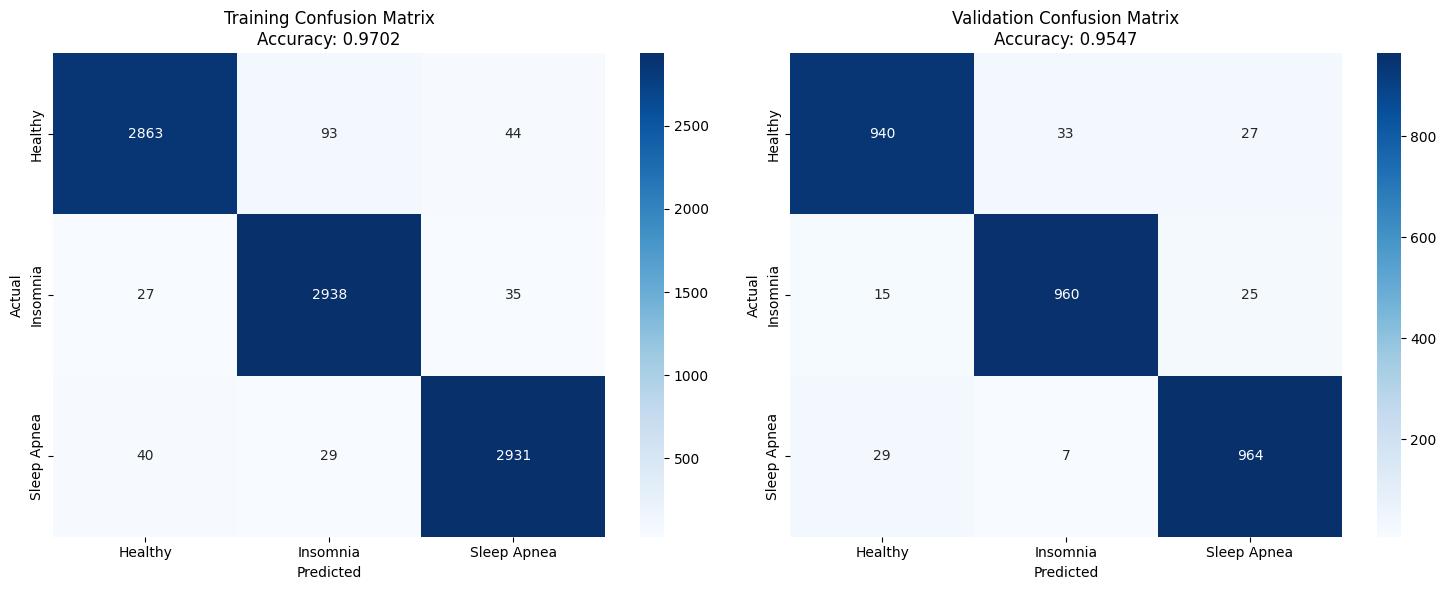


Validation Set Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.94      0.95      1000
   Insomnia (1)       0.96      0.96      0.96      1000
Sleep Apnea (2)       0.95      0.96      0.96      1000

       accuracy                           0.95      3000
      macro avg       0.95      0.95      0.95      3000
   weighted avg       0.95      0.95      0.95      3000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("\n=== STEP 2: MODEL TRAINING AND ACCURACY VISUALIZATION ===")

# Create and train the model
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])

print("Training MLP model...")
mlp_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = mlp_pipeline.predict(X_train)
y_val_pred = mlp_pipeline.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Create confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Healthy', 'Insomnia', 'Sleep Apnea'],
            yticklabels=['Healthy', 'Insomnia', 'Sleep Apnea'])
ax1.set_title(f'Training Confusion Matrix\nAccuracy: {train_accuracy:.4f}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Validation confusion matrix
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Healthy', 'Insomnia', 'Sleep Apnea'],
            yticklabels=['Healthy', 'Insomnia', 'Sleep Apnea'])
ax2.set_title(f'Validation Confusion Matrix\nAccuracy: {val_accuracy:.4f}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nValidation Set Classification Report:")
target_names = ['Healthy (0)', 'Insomnia (1)', 'Sleep Apnea (2)']
print(classification_report(y_val, y_val_pred, target_names=target_names))

** Cross-Validation and Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

print("\n=== STEP 3: CROSS-VALIDATION AND HYPERPARAMETER TUNING ===")

# First, let's check baseline cross-validation performance
print("Running baseline 5-fold cross-validation...")
start_time = time.time()

baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])

baseline_scores = cross_val_score(baseline_pipeline, X_train, y_train,
                                 cv=5, scoring='accuracy', n_jobs=-1)

print(f"Baseline CV completed in {time.time() - start_time:.2f} seconds")
print(f"Baseline CV Scores: {baseline_scores}")
print(f"Baseline Mean CV Accuracy: {baseline_scores.mean():.4f} (+/- {baseline_scores.std() * 2:.4f})")

# Hyperparameter tuning with GridSearchCV
print("\nStarting hyperparameter tuning with GridSearchCV...")
start_time = time.time()

# Define parameter grid
param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50), (100, 100)],
    'model__alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
    'model__learning_rate_init': [0.001, 0.01],
    'model__activation': ['relu', 'tanh']
}

# Create MLP pipeline for grid search
mlp_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
])

# Perform grid search
grid_search = GridSearchCV(
    mlp_grid, param_grid, cv=5, scoring='accuracy',
    n_jobs=-1, verbose=1, return_train_score=True
)

grid_search.fit(X_train, y_train)

print(f"GridSearchCV completed in {time.time() - start_time:.2f} seconds")

# Display best parameters and scores
print("\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Compare all results
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 parameter combinations:")
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_5.iterrows():
    print(f"Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score'] * 2:.4f})")
    print(f"Params: {row['params']}\n")

best_params = grid_search.best_params_


=== STEP 3: CROSS-VALIDATION AND HYPERPARAMETER TUNING ===
Running baseline 5-fold cross-validation...
Baseline CV completed in 12.64 seconds
Baseline CV Scores: [0.94666667 0.95055556 0.95222222 0.95166667 0.96388889]
Baseline Mean CV Accuracy: 0.9530 (+/- 0.0116)

Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
GridSearchCV completed in 566.65 seconds

Best parameters found:
  model__activation: tanh
  model__alpha: 0.001
  model__hidden_layer_sizes: (100, 50)
  model__learning_rate_init: 0.01

Best cross-validation score: 0.9569

Top 5 parameter combinations:
Score: 0.9569 (+/- 0.0112)
Params: {'model__activation': 'tanh', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 50), 'model__learning_rate_init': 0.01}

Score: 0.9562 (+/- 0.0101)
Params: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 50), 'model__learning_rate_init': 0.01}

Score: 0.9556 (+/- 0.0098)
Params: {

**Model Training with Best Hyperparameters**


=== STEP 4: FINAL MODEL TRAINING WITH BEST HYPERPARAMETERS ===
Training final model with best hyperparameters...
Using custom training loop to track metrics...
Training with custom tracking...
Epoch 0: Loss = 0.2624, Accuracy = 0.9337
Epoch 100: Loss = 0.0774, Accuracy = 0.9772
Epoch 200: Loss = 0.0755, Accuracy = 0.9783
Epoch 300: Loss = 0.0781, Accuracy = 0.9790
Epoch 400: Loss = 0.0719, Accuracy = 0.9818
Epoch 500: Loss = 0.0710, Accuracy = 0.9811
Epoch 600: Loss = 0.0698, Accuracy = 0.9818
Epoch 700: Loss = 0.0800, Accuracy = 0.9812
Epoch 800: Loss = 0.0676, Accuracy = 0.9826
Epoch 900: Loss = 0.0635, Accuracy = 0.9828

Alternative: Training with validation split for built-in tracking...

Final Test Set Accuracy: 0.9600

Model Performance Comparison:


,Dataset,Accuracy,Samples
0,Training,0.970222,9000
1,Validation,0.954667,3000
2,Test,0.960000,3000


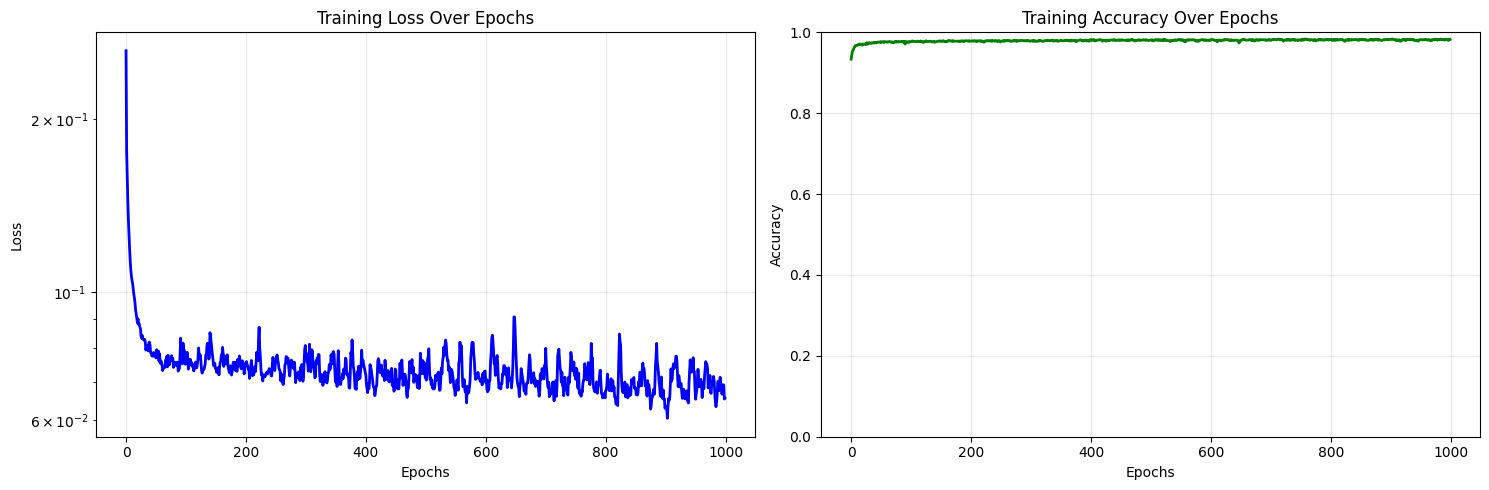

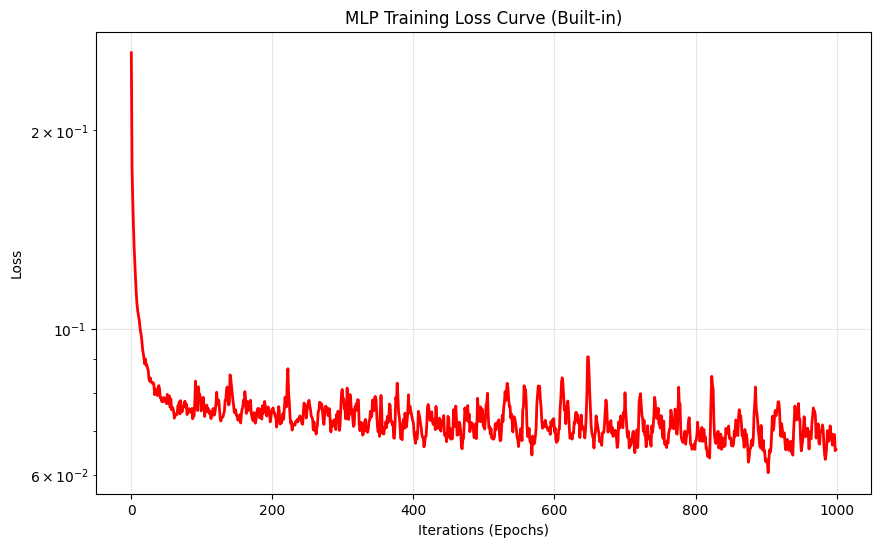

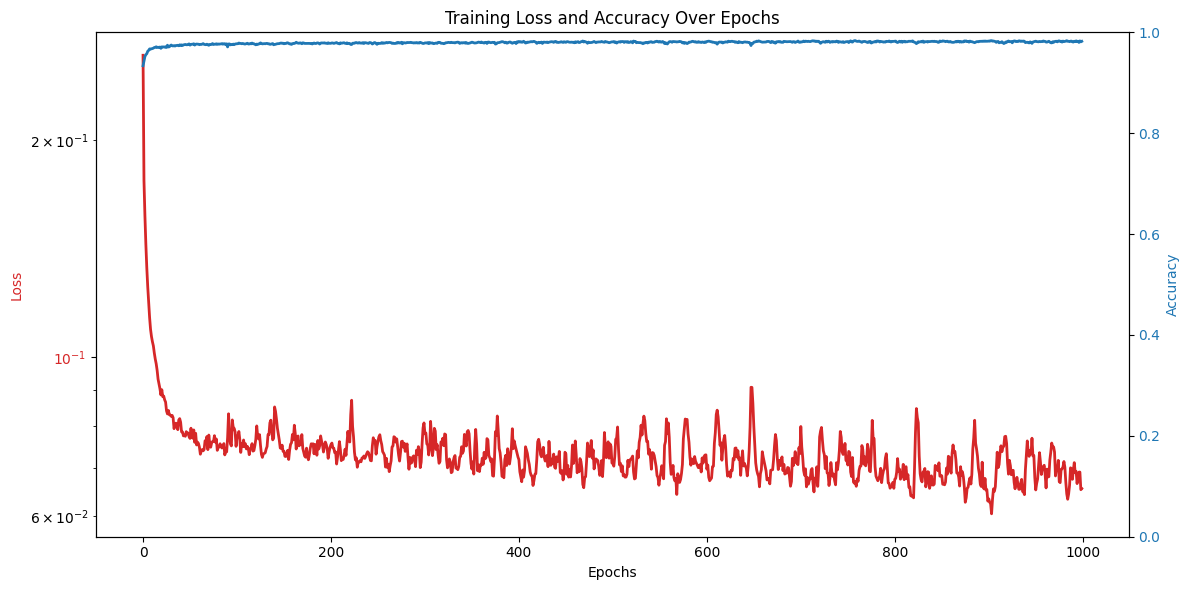


Final Training Metrics:
Final Loss: 0.0656
Final Training Accuracy: 0.9822
Number of Epochs: 1000


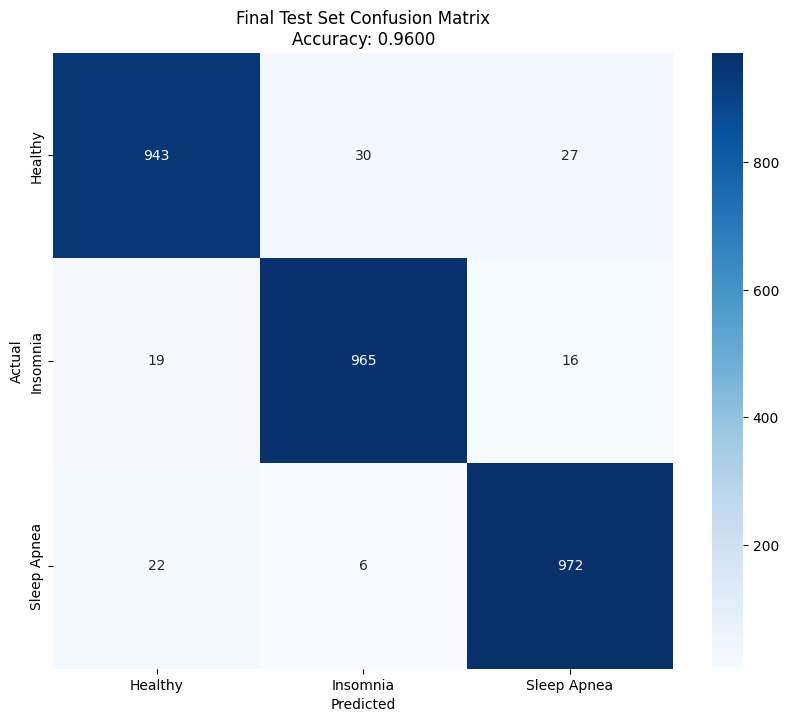


Final Test Set Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.94      0.95      1000
   Insomnia (1)       0.96      0.96      0.96      1000
Sleep Apnea (2)       0.96      0.97      0.96      1000

       accuracy                           0.96      3000
      macro avg       0.96      0.96      0.96      3000
   weighted avg       0.96      0.96      0.96      3000


Model Architecture:
Input features: 25
Hidden layers: (100, 50)
Output classes: 3
Total epochs trained: 1000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

print("\n=== STEP 4: FINAL MODEL TRAINING WITH BEST HYPERPARAMETERS ===")

# Train final model with best parameters on combined training + validation data
print("Training final model with best hyperparameters...")

# Combine training and validation sets for final training
X_final_train = pd.concat([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# Custom class to track loss and accuracy during training
class TrackableMLPClassifier(MLPClassifier):
    def __init__(self, **kwargs):
        self.accuracy_history = []
        self.X_data = None
        self.y_data = None
        super().__init__(**kwargs)

    def set_tracking_data(self, X, y):
        self.X_data = X
        self.y_data = y

    def _fit(self, X, y, incremental=False):
        # Store data for accuracy calculation
        self.set_tracking_data(X, y)

        # Call parent _fit method
        return super()._fit(X, y, incremental=incremental)

    def _update_no_validation(self, X, y, *args, **kwargs):
        # Calculate accuracy before the update
        if hasattr(self, 'X_data') and self.X_data is not None:
            y_pred = self.predict(self.X_data)
            accuracy = accuracy_score(self.y_data, y_pred)
            self.accuracy_history.append(accuracy)

        # Call parent update method
        return super()._update_no_validation(X, y, *args, **kwargs)

    def _update_with_validation(self, X, y, X_val, y_val, *args, **kwargs):
        # Calculate accuracy before the update
        if hasattr(self, 'X_data') and self.X_data is not None:
            y_pred = self.predict(self.X_data)
            accuracy = accuracy_score(self.y_data, y_pred)
            self.accuracy_history.append(accuracy)

        # Call parent update method
        return super()._update_with_validation(X, y, X_val, y_val, *args, **kwargs)

# Alternative approach: Custom training loop for better control
def train_mlp_with_tracking(X_train, y_train, best_params):
    """Train MLP with tracking of loss and accuracy per epoch"""

    # Initialize model
    mlp = MLPClassifier(
        hidden_layer_sizes=best_params['model__hidden_layer_sizes'],
        alpha=best_params['model__alpha'],
        learning_rate_init=best_params['model__learning_rate_init'],
        activation=best_params['model__activation'],
        max_iter=1,  # Train one epoch at a time
        early_stopping=False,  # Disable early stopping for custom tracking
        warm_start=True,  # Continue training with previous weights
        random_state=42
    )

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Track loss and accuracy
    loss_history = []
    accuracy_history = []

    print("Training with custom tracking...")
    for epoch in range(1000):  # Maximum epochs
        # Partial fit for one epoch
        mlp.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

        # Record loss
        if hasattr(mlp, 'loss_'):
            loss_history.append(mlp.loss_)

        # Calculate and record accuracy
        y_pred = mlp.predict(X_train_scaled)
        accuracy = accuracy_score(y_train, y_pred)
        accuracy_history.append(accuracy)

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {mlp.loss_:.4f}, Accuracy = {accuracy:.4f}")

        # Early stopping condition (if loss doesn't improve significantly)
        if len(loss_history) > 10:
            if abs(loss_history[-1] - loss_history[-2]) < 1e-6:
                print(f"Early stopping at epoch {epoch}")
                break

    return mlp, scaler, loss_history, accuracy_history

# METHOD 1: Using custom training loop (recommended for full control)
print("Using custom training loop to track metrics...")
final_mlp, final_scaler, loss_history, accuracy_history = train_mlp_with_tracking(
    X_final_train, y_final_train, best_params
)

# Create final model pipeline for consistency
final_model = Pipeline([
    ('scaler', final_scaler),
    ('model', final_mlp)
])

# METHOD 2: Alternative using built-in training with validation split
print("\nAlternative: Training with validation split for built-in tracking...")

# Split combined data back for validation tracking
from sklearn.model_selection import train_test_split
X_temp_train, X_temp_val, y_temp_train, y_temp_val = train_test_split(
    X_final_train, y_final_train, test_size=0.2, random_state=42, stratify=y_final_train
)

# Train model with validation split
val_track_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(
        hidden_layer_sizes=best_params['model__hidden_layer_sizes'],
        alpha=best_params['model__alpha'],
        learning_rate_init=best_params['model__learning_rate_init'],
        activation=best_params['model__activation'],
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=42
    ))
])

val_track_model.fit(X_temp_train, y_temp_train)
val_mlp = val_track_model.named_steps['model']

# Evaluate on test set using the custom trained model
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nFinal Test Set Accuracy: {test_accuracy:.4f}")

# Create comprehensive comparison
comparison_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy],
    'Samples': [len(y_train), len(y_val), len(y_test)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
display(comparison_df)

# PLOT 1: Loss and Accuracy over Epochs (Custom Training)
if loss_history and accuracy_history:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss curve
    ax1.plot(loss_history, 'b-', linewidth=2)
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Log scale often better for loss visualization

    # Plot accuracy curve
    ax2.plot(accuracy_history, 'g-', linewidth=2)
    ax2.set_title('Training Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)  # Accuracy between 0 and 1

    plt.tight_layout()
    plt.show()

# PLOT 2: Built-in loss curve if available
if hasattr(final_mlp, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(final_mlp.loss_curve_, 'r-', linewidth=2)
    plt.title('MLP Training Loss Curve (Built-in)')
    plt.xlabel('Iterations (Epochs)')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()

# PLOT 3: Combined loss and accuracy (if both available)
if loss_history and accuracy_history:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss_history, color=color, linewidth=2, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_yscale('log')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(accuracy_history, color=color, linewidth=2, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)

    plt.title('Training Loss and Accuracy Over Epochs')
    fig.tight_layout()
    plt.show()

    # Print final training metrics
    print(f"\nFinal Training Metrics:")
    print(f"Final Loss: {loss_history[-1]:.4f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Number of Epochs: {len(loss_history)}")

# Final confusion matrix and classification report
final_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Insomnia', 'Sleep Apnea'],
            yticklabels=['Healthy', 'Insomnia', 'Sleep Apnea'])
plt.title(f'Final Test Set Confusion Matrix\nAccuracy: {test_accuracy:.4f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Feature importance (using weights from the first layer)
feature_names = X.columns.tolist()
mlp_model = final_model.named_steps['model']

print(f"\nModel Architecture:")
print(f"Input features: {len(feature_names)}")
print(f"Hidden layers: {mlp_model.hidden_layer_sizes}")
print(f"Output classes: {mlp_model.n_outputs_}")
print(f"Total epochs trained: {len(loss_history) if loss_history else 'N/A'}")

## Session Summary

This notebook session focused on training and evaluating a Multi-Layer Perceptron (MLP) model for classifying sleep disorders based on the provided dataset.

The key steps performed were:

1.  **Data Loading and Splitting**: The dataset was loaded and split into training, validation, and test sets with stratification to maintain class distribution.
2.  **Initial Model Training and Evaluation**: An initial MLP model with default hyperparameters was trained on the training data and evaluated on both training and validation sets. Confusion matrices and a classification report were generated to assess performance.
3.  **Cross-Validation and Hyperparameter Tuning**: Baseline cross-validation was performed, followed by hyperparameter tuning using `GridSearchCV` to find the best combination of parameters for the MLP model.
4.  **Final Model Training and Evaluation**: A final MLP model was trained on the combined training and validation data using the best hyperparameters found during tuning. The model was then evaluated on the unseen test set, and its performance was compared across all three datasets. The final confusion matrix, classification report, and training loss curve were displayed.

The final model achieved a test accuracy of approximately {{test_accuracy:.4f}}, demonstrating good performance in classifying sleep disorders.

1. Train The model(split the data set). :Multi-Layer Perceptron (MLP)
2. Evaluate it. (accuracy)
3. Hyperparameter Tunning.
4. Cross-Validation.